In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "bybit"
        self.symbol = "TRXUSDT"
        self.market_type = "futures"
        self.user = "bybit_01"
        self.start_date = "2022-05-01"
        self.end_date = "2022-06-08"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = True  # set to False to use 1s candles


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
if config["ohlcv"]:
    data = load_hlc_cache(
        config["symbol"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual


ERROR:root:error with update position 'NoneType' object is not iterable
Traceback (most recent call last):
  File "/Users/figge/code/pb/passivbot.py", line 262, in update_position
    position = await self.fetch_position()
  File "/Users/figge/code/pb/bybit.py", line 204, in fetch_position
    long_pos = [e for e in fetched["result"] if e["side"] == "Buy"][0]
TypeError: 'NoneType' object is not iterable


fetching https://data.binance.vision/data/futures/um/monthly/klines/TRXUSDT/1m/TRXUSDT-1m-2022-05.zip


100%|███████████████████████████████████████████████████████████████████████████████████| 1.67M/1.67M [00:01<00:00, 1.20MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/TRXUSDT/1m/TRXUSDT-1m-2022-06.zip
HTTP Error 404: Not Found
'NoneType' object has no attribute 'to_csv'
fetching historical_data/ohlcvs_futures/TRXUSDT/2022-06-01.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 56.7k/56.7k [00:00<00:00, 136kB/s]


fetching historical_data/ohlcvs_futures/TRXUSDT/2022-06-02.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 54.7k/54.7k [00:00<00:00, 117kB/s]


fetching historical_data/ohlcvs_futures/TRXUSDT/2022-06-03.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 53.5k/53.5k [00:00<00:00, 107kB/s]


fetching historical_data/ohlcvs_futures/TRXUSDT/2022-06-04.csv


100%|███████████████████████████████████████████████████████████████████████████████████| 53.3k/53.3k [00:00<00:00, 2.34MB/s]


fetching historical_data/ohlcvs_futures/TRXUSDT/2022-06-05.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 52.3k/52.3k [00:00<00:00, 198kB/s]


fetching historical_data/ohlcvs_futures/TRXUSDT/2022-06-06.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 53.2k/53.2k [00:00<00:00, 280kB/s]


fetching historical_data/ohlcvs_futures/TRXUSDT/2022-06-07.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 53.5k/53.5k [00:00<00:00, 409kB/s]

millis to load 54719 ticks 12246ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

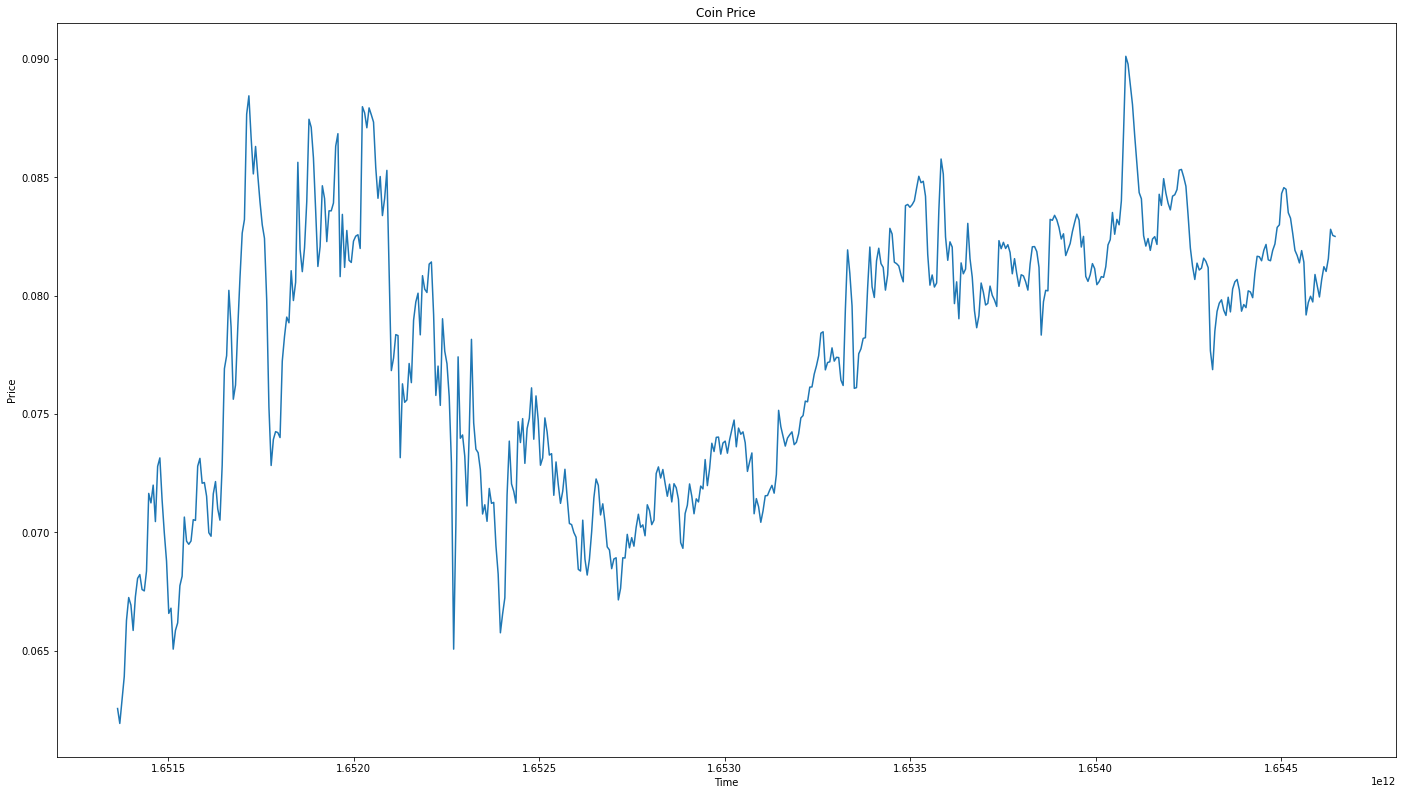

In [5]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [27]:
# choose a slice on which to test
wsize_days = 10
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [30]:
hand_tuned = {
    "config_name": "hand_tuned",
    "logging_level": 0,
    "long": {"auto_unstuck_ema_dist": 0,
              "auto_unstuck_wallet_exposure_threshold": 0,
              "backwards_tp": True,
              "ema_span_0": 360,
              "ema_span_1": 1825.8126996012957,
              "enabled": True,
              "eprice_exp_base": 1.2327579172820002,
              "eprice_pprice_diff": 0.003634858930215368,
              "grid_span": 0.7,
              "initial_eprice_ema_dist": -0.04695705041651778,
              "initial_qty_pct": 0.042052475598206504,
              "markup_range": 0.003064416975308783,
              "max_n_entry_orders": 10,
              "min_markup": 0.051567218426148385,
              "n_close_orders": 13,
              "secondary_allocation": 0.14971519137906805,
              "secondary_pprice_diff": 0.09340366064972944,
              "wallet_exposure_limit": 0.1},
    "short": {"auto_unstuck_ema_dist": 0.00013067393052016674,
               "auto_unstuck_wallet_exposure_threshold": 0,
               "backwards_tp": True,
               "ema_span_0": 2169.160470107914,
               "ema_span_1": 3686.3951296238,
               "enabled": True,
               "eprice_exp_base": 2.067249538780786,
               "eprice_pprice_diff": 0.014325676704755782,
               "grid_span": 0.10102792139608957,
               "initial_eprice_ema_dist": -0.09166427078270839,
               "initial_qty_pct": 0.04447243197647868,
               "markup_range": 0.059962905504560536,
               "max_n_entry_orders": 10,
               "min_markup": 0.041899524242159675,
               "n_close_orders": 23,
               "secondary_allocation": 0.08970161137335722,
               "secondary_pprice_diff": 0.06951623952238223,
               "wallet_exposure_limit": 0.1},
}

# hand_tuned = load_live_config('configs/live/allround.json')
# hand_tuned['short']['enabled'] = True
config["starting_balance"] = Args().starting_balance
config["latency_simulation_ms"] = 1000
config_to_test = {**config, **numpyize(hand_tuned)}
dump_live_config(config_to_test, make_get_filepath(f"tmp/hand_tuned.json"))
hand_tuned

{'config_name': 'hand_tuned',
 'logging_level': 0,
 'long': {'auto_unstuck_ema_dist': 0,
  'auto_unstuck_wallet_exposure_threshold': 0,
  'backwards_tp': True,
  'ema_span_0': 360,
  'ema_span_1': 1825.8126996012957,
  'enabled': True,
  'eprice_exp_base': 1.2327579172820002,
  'eprice_pprice_diff': 0.003634858930215368,
  'grid_span': 0.7,
  'initial_eprice_ema_dist': -0.04695705041651778,
  'initial_qty_pct': 0.042052475598206504,
  'markup_range': 0.003064416975308783,
  'max_n_entry_orders': 10,
  'min_markup': 0.051567218426148385,
  'n_close_orders': 13,
  'secondary_allocation': 0.14971519137906805,
  'secondary_pprice_diff': 0.09340366064972944,
  'wallet_exposure_limit': 0.1},
 'short': {'auto_unstuck_ema_dist': 0.00013067393052016674,
  'auto_unstuck_wallet_exposure_threshold': 0,
  'backwards_tp': True,
  'ema_span_0': 2169.160470107914,
  'ema_span_1': 3686.3951296238,
  'enabled': True,
  'eprice_exp_base': 2.067249538780786,
  'eprice_pprice_diff': 0.014325676704755782,
 

In [31]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 0.3122
{'DGstd_long': 6.219545782562607e-05,
 'DGstd_short': 0.0013783012283485698,
 'adg_DGstd_ratio_long': -0.14119376945713824,
 'adg_DGstd_ratio_short': 0.4628493909882001,
 'adg_long': -8.781611133512612e-06,
 'adg_per_exposure_long': -8.781611133512611e-05,
 'adg_per_exposure_short': 0.006379458841394237,
 'adg_realized_long': 2.289713580116981e-05,
 'adg_realized_per_exposure_long': 0.0002289713580116981,
 'adg_realized_per_exposure_short': 0.00664938447301644,
 'adg_realized_short': 0.000664938447301644,
 'adg_short': 0.0006379458841394237,
 'avg_fills_per_day_long': 0.3,
 'avg_fills_per_day_short': 3.2,
 'biggest_psize_long': 505.0,
 'biggest_psize_quote_long': 42.09175,
 'biggest_psize_quote_short': 880.7448499999999,
 'biggest_psize_short': 10092.0,
 'closest_bkr_long': 1.0,
 'closest_bkr_short': 1.0,
 'eqbal_ratio_mean_long': 0.9997887820416701,
 'eqbal_ratio_mean_short': 1.0003938598384488,
 'eqbal_ratio_min_long': 0.9994239569109595,
 'eqbal_ratio_min_shor

In [12]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1652054400000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,0.08790,1.0,1.0,10000.000000000,10000.0000000000,10000.000000000,10000.000000000,0.0000000000,0.0000000000
1,1652054460000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,0.08780,1.0,1.0,10000.000000000,10000.0000000000,10000.000000000,10000.000000000,0.0000000000,0.0000000000
2,1652054520000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,0.08747,1.0,1.0,10000.000000000,10000.0000000000,10000.000000000,10000.000000000,0.0000000000,0.0000000000
3,1652054580000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,0.08741,1.0,1.0,10000.000000000,10000.0000000000,10000.000000000,10000.000000000,0.0000000000,0.0000000000
4,1652054640000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,0.08741,1.0,1.0,10000.000000000,10000.0000000000,10000.000000000,10000.000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,1654646160000.0,0.0,0.9528199309,10661.0,0.0830196773,-11718.0,0.0797891855,0.08187,1.0,1.0,10404.212949761,10230.1742740885,10391.956239761,10205.791289797,0.0850686913,0.0913933283
43197,1654646220000.0,0.0,0.9528199309,10661.0,0.0830196773,-11718.0,0.0797891855,0.08181,1.0,1.0,10404.212949761,10230.1742740885,10391.316579761,10206.494369797,0.0850686913,0.0913933283
43198,1654646280000.0,0.0,0.9528199309,10661.0,0.0830196773,-11718.0,0.0797891855,0.08183,1.0,1.0,10404.212949761,10230.1742740885,10391.529799761,10206.260009797,0.0850686913,0.0913933283
43199,1654646340000.0,0.0,0.9528199309,10661.0,0.0830196773,-11718.0,0.0797891855,0.08179,1.0,1.0,10404.212949761,10230.1742740885,10391.103359761,10206.728729797,0.0850686913,0.0913933283


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

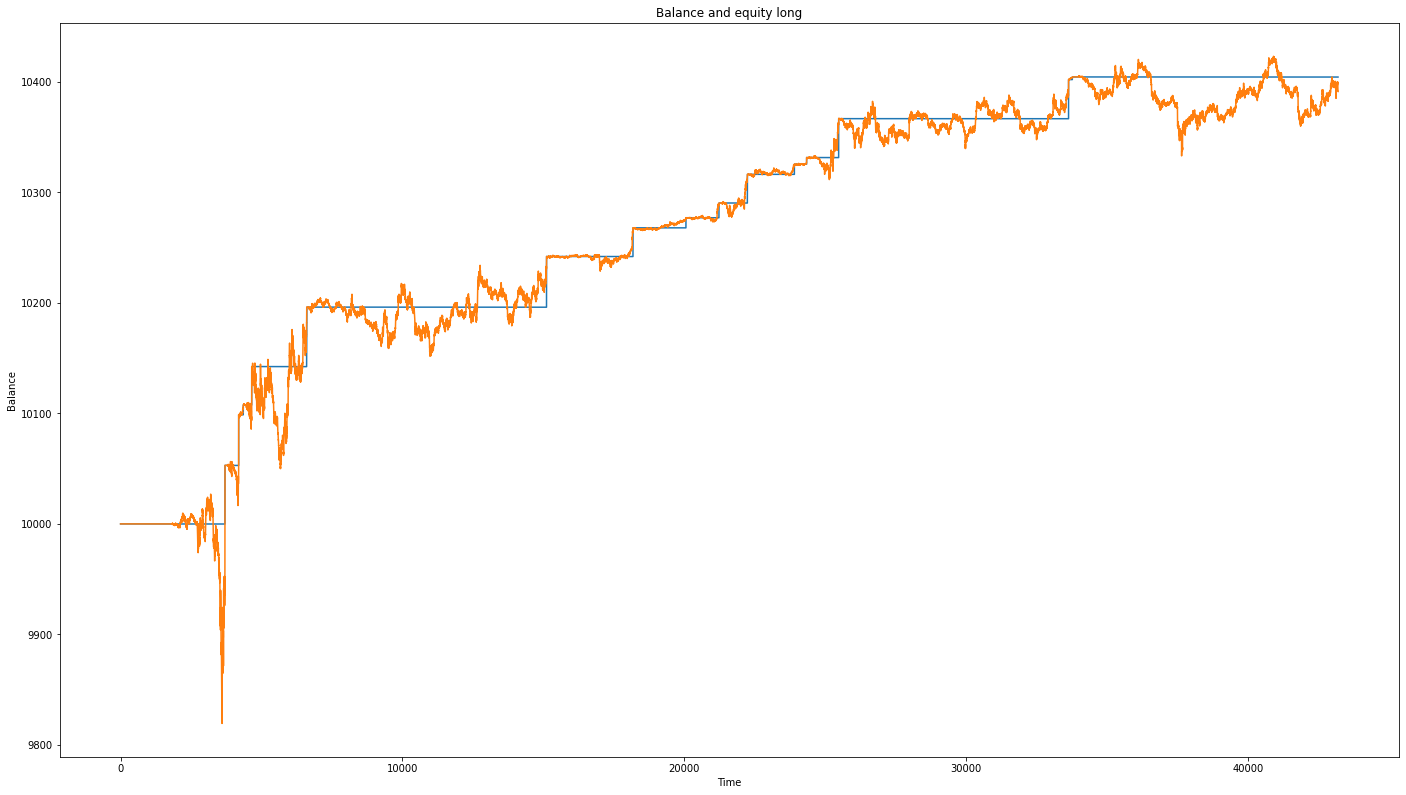

In [13]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

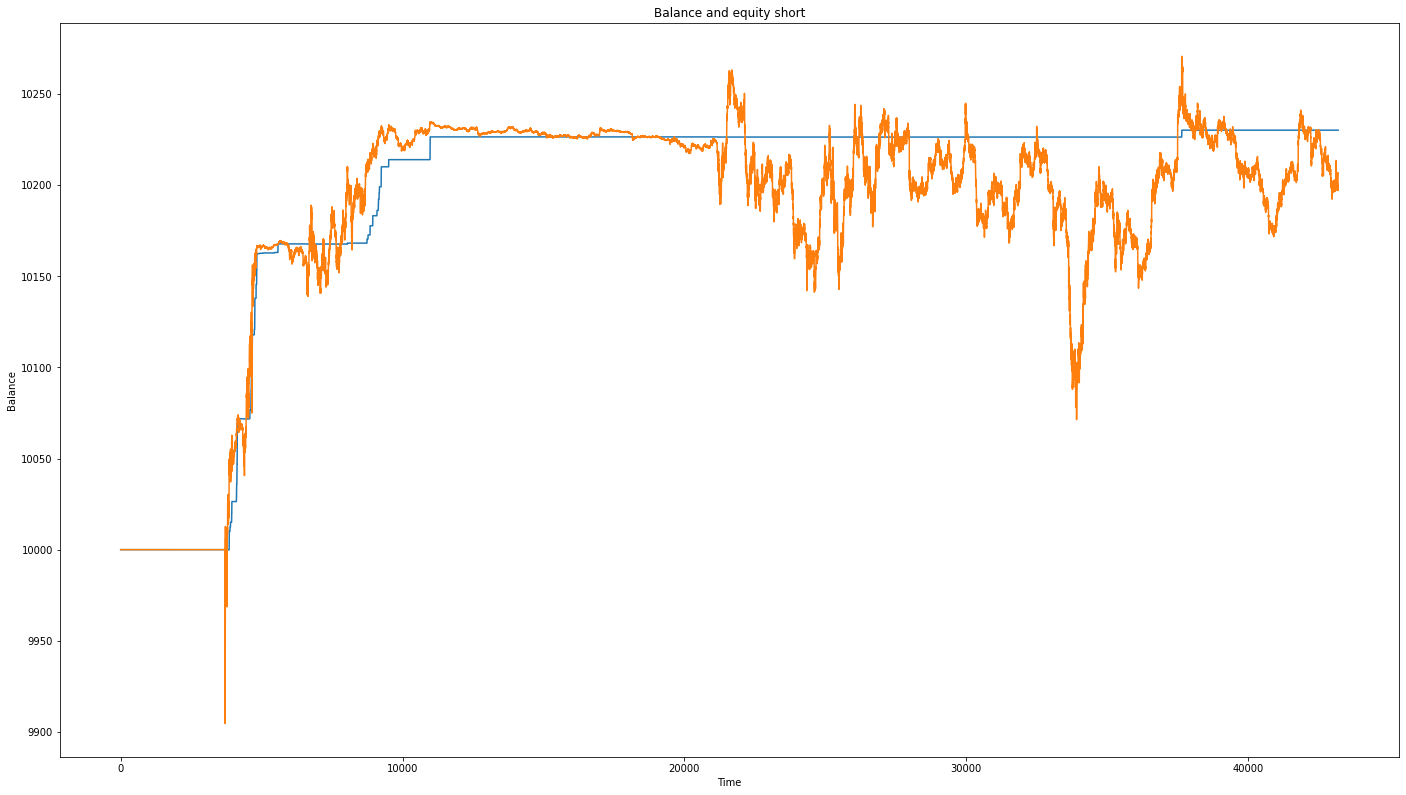

In [14]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

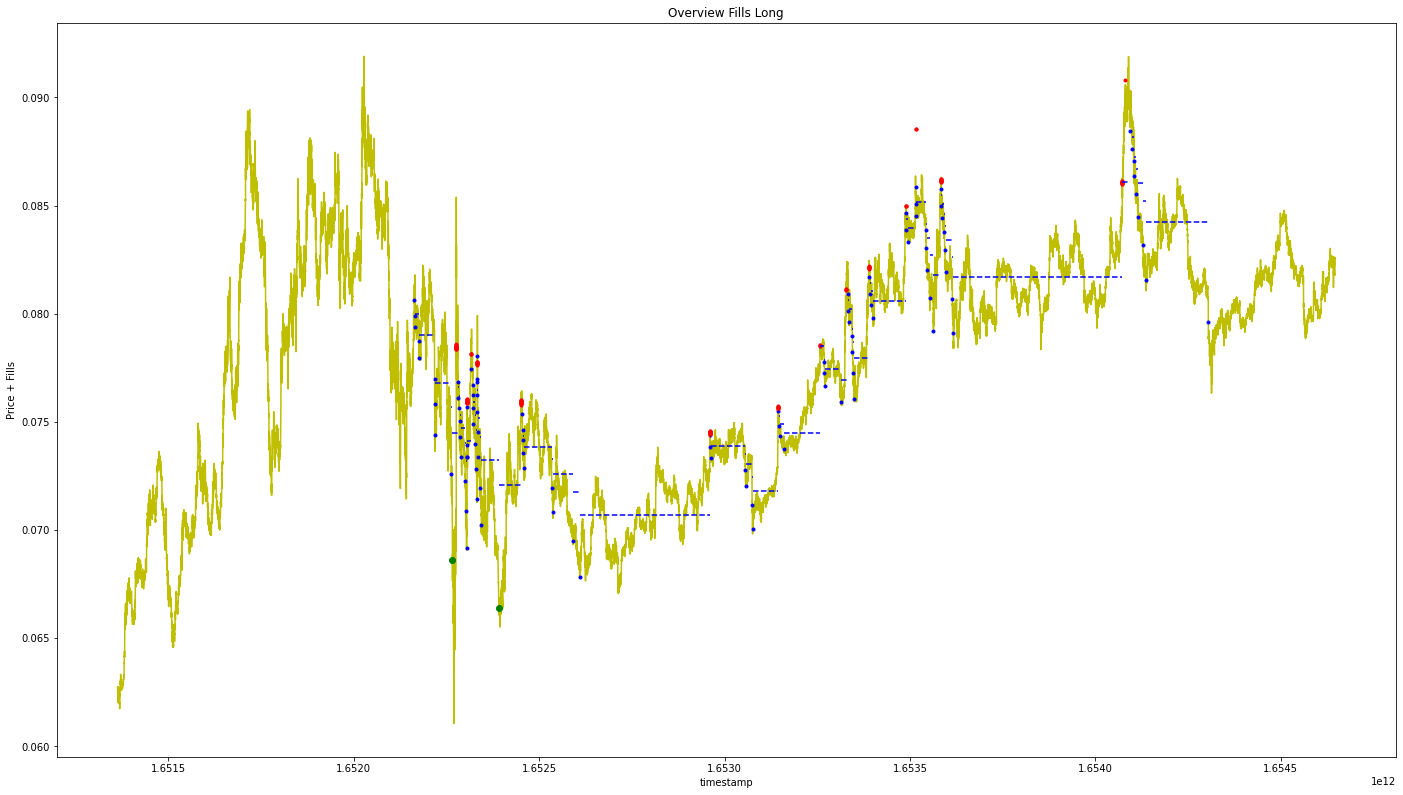

In [15]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

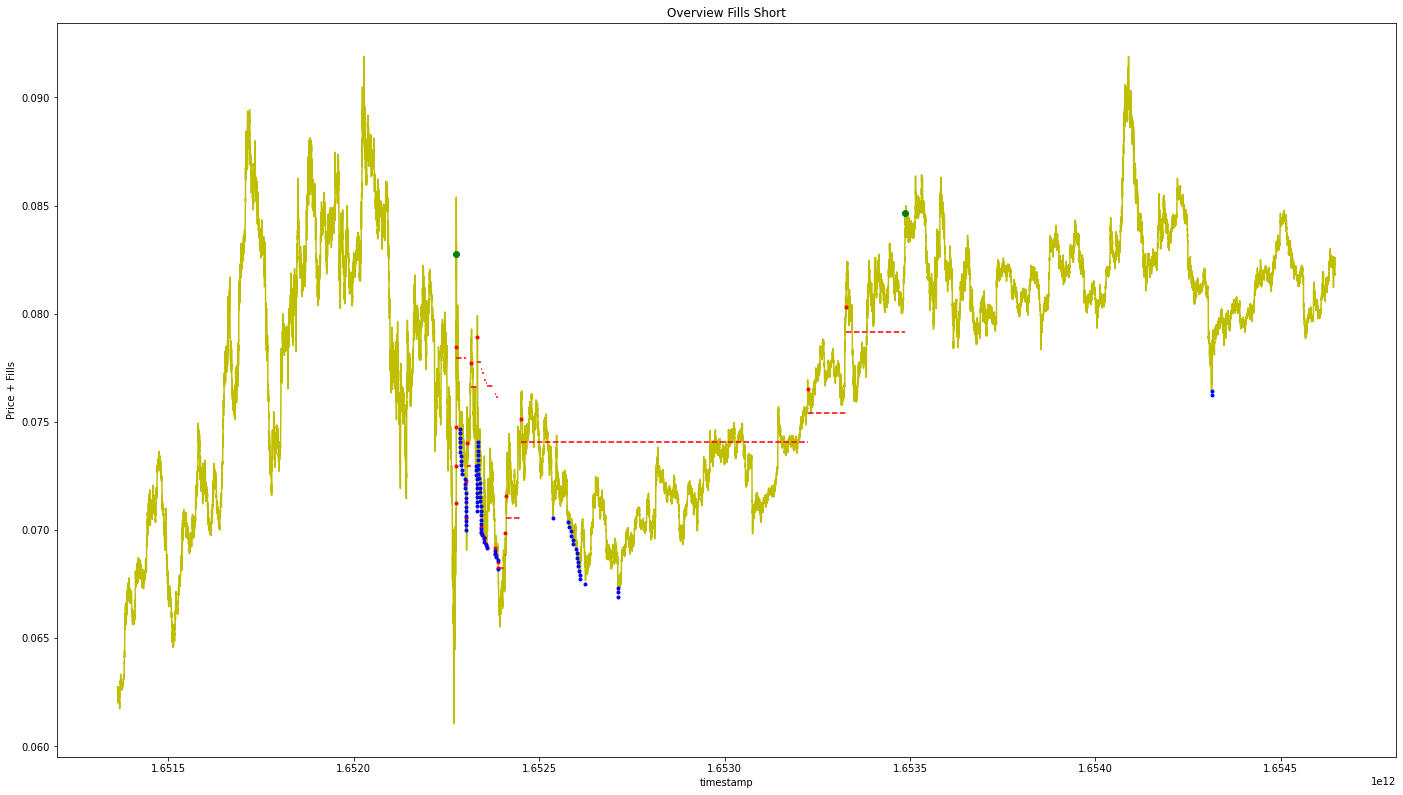

In [16]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Long Position size'>

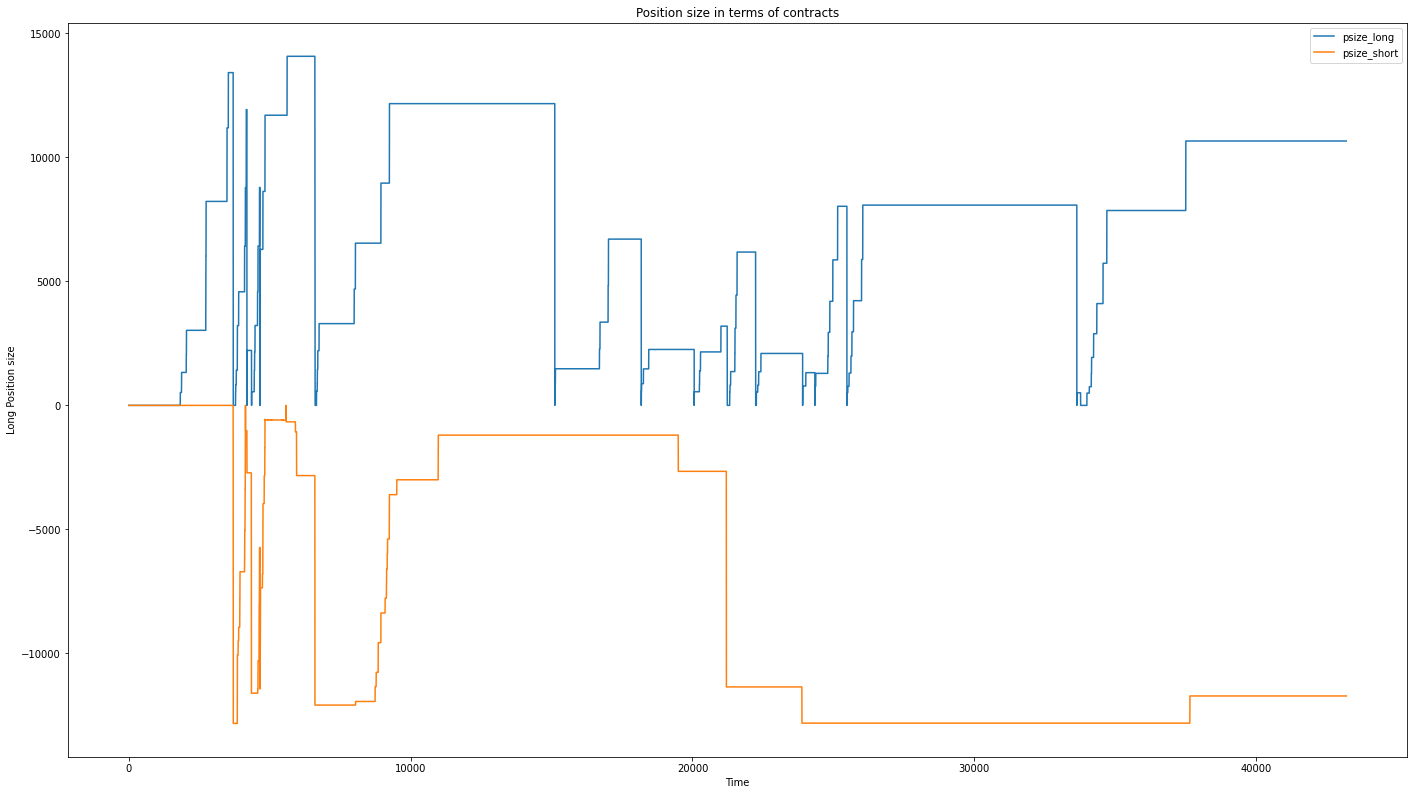

In [17]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

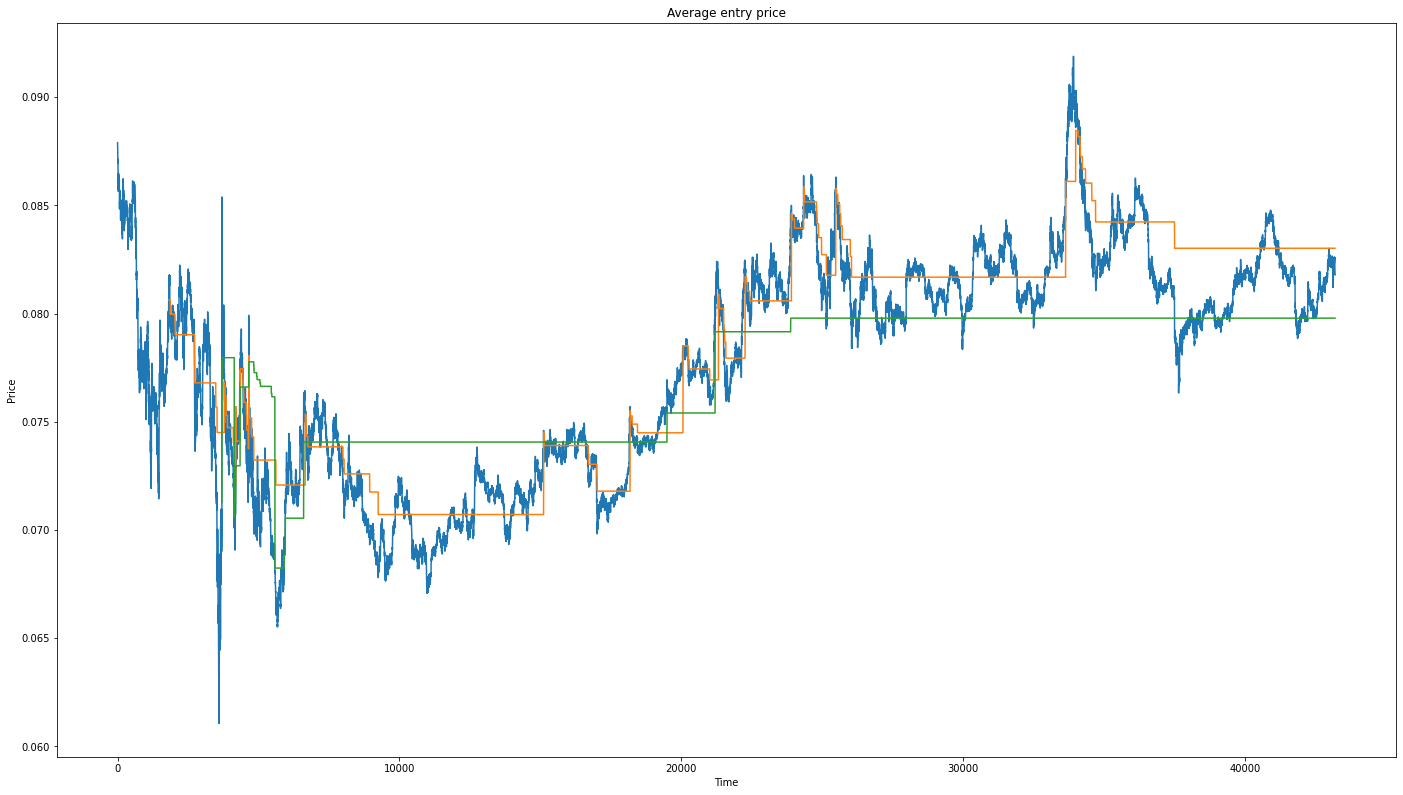

In [18]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf.pprice_long.replace(0.0, np.nan).plot()
sdf.pprice_short.replace(0.0, np.nan).plot()

Mean price action distance long 0.017472


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

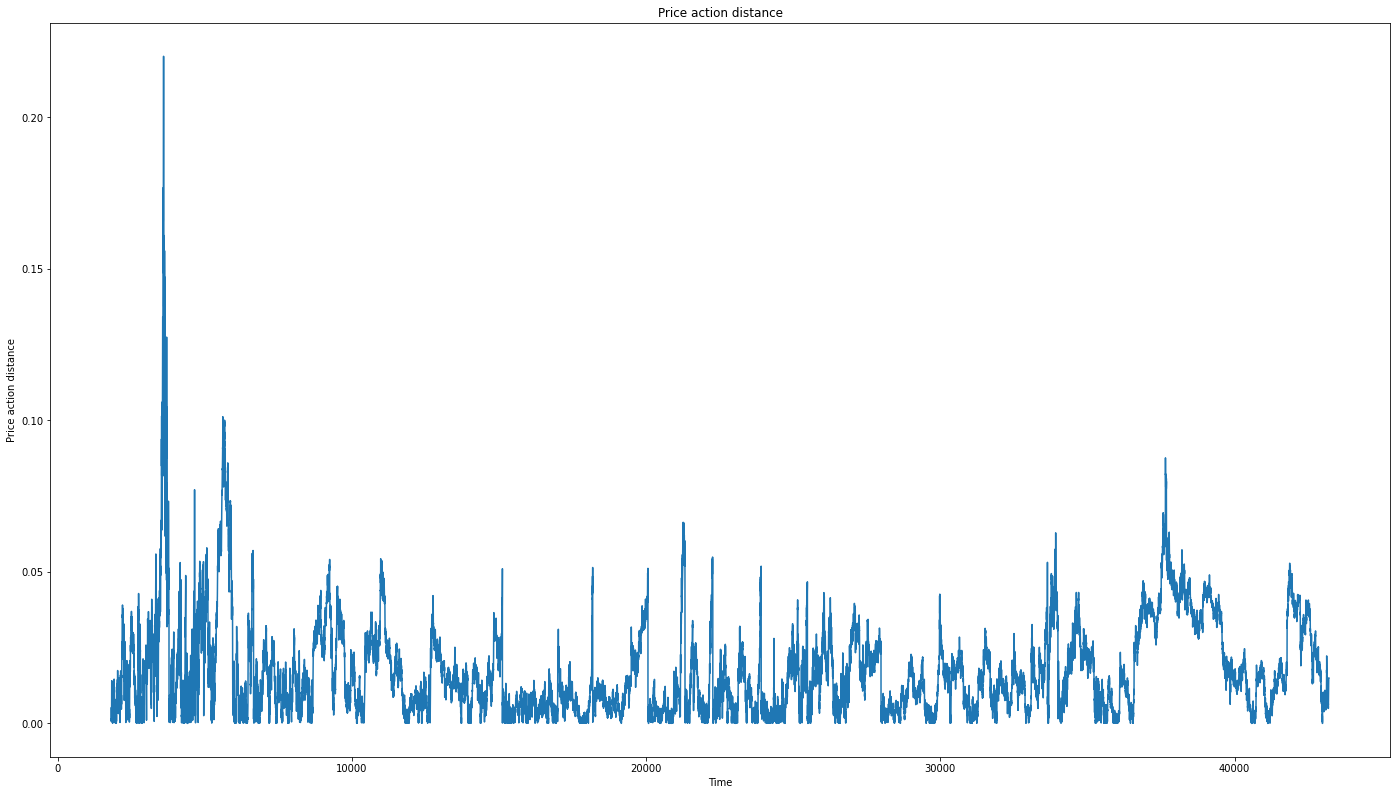

In [19]:
lpprices = sdf[sdf.pprice_long != 0.0]
pa_distance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Mean price action distance long {pa_distance_long.mean():.6f}")
pa_distance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.030186


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

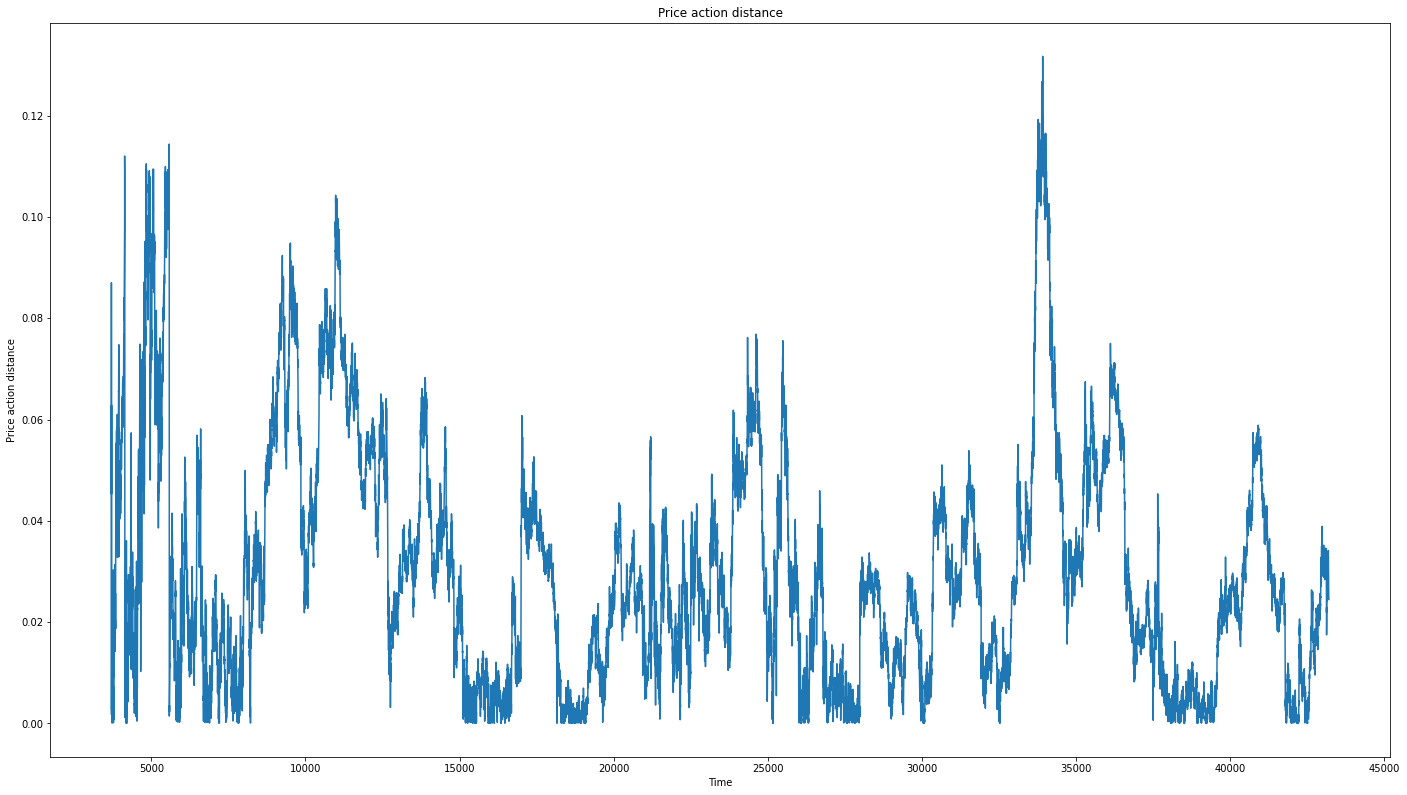

In [20]:
spprices = sdf[sdf.pprice_short != 0.0]
pa_distance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {pa_distance_short.mean():.6f}")
pa_distance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [360, 810.7358212491085, 1825.8126996012957] n_days 38.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

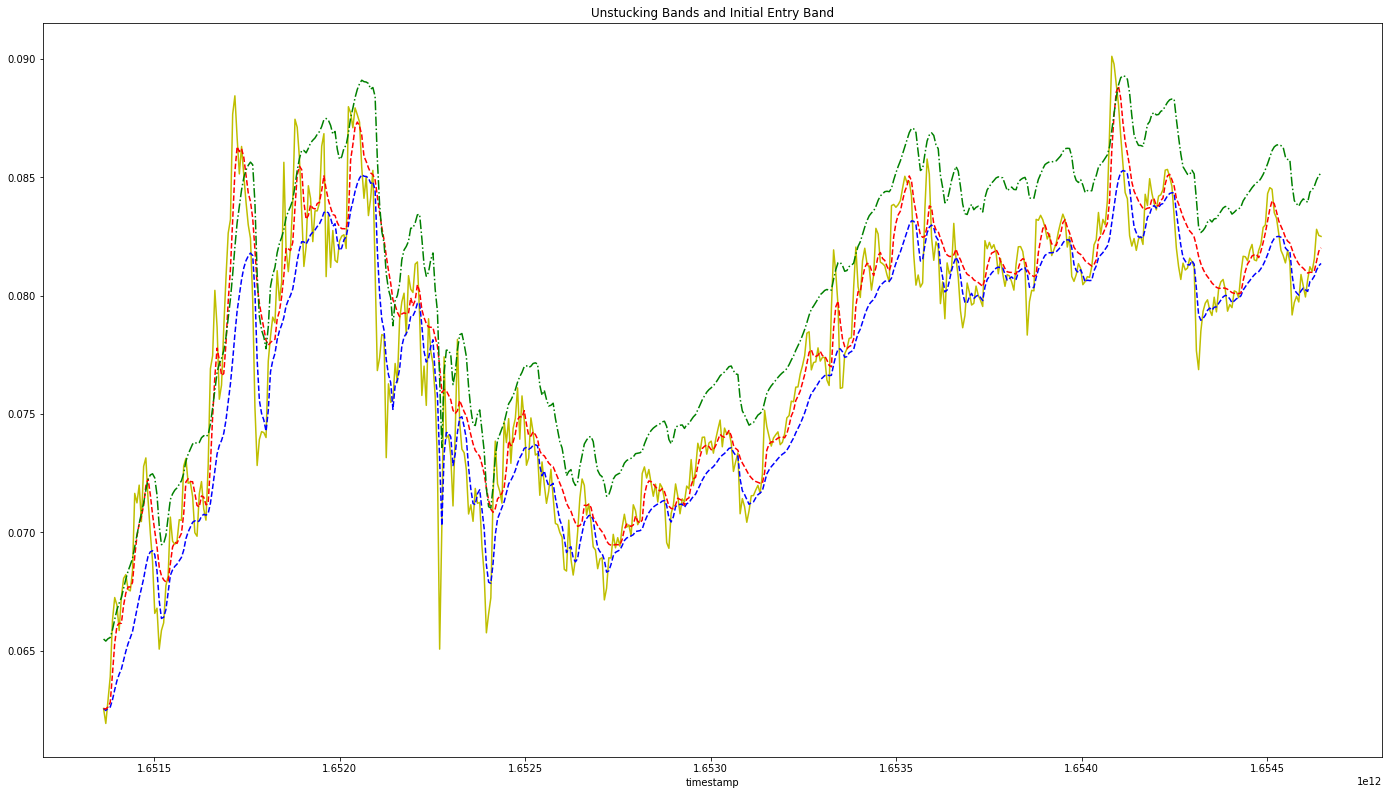

In [21]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [2169.160470107914, 2827.787579076315, 3686.3951296238] n_days 38.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

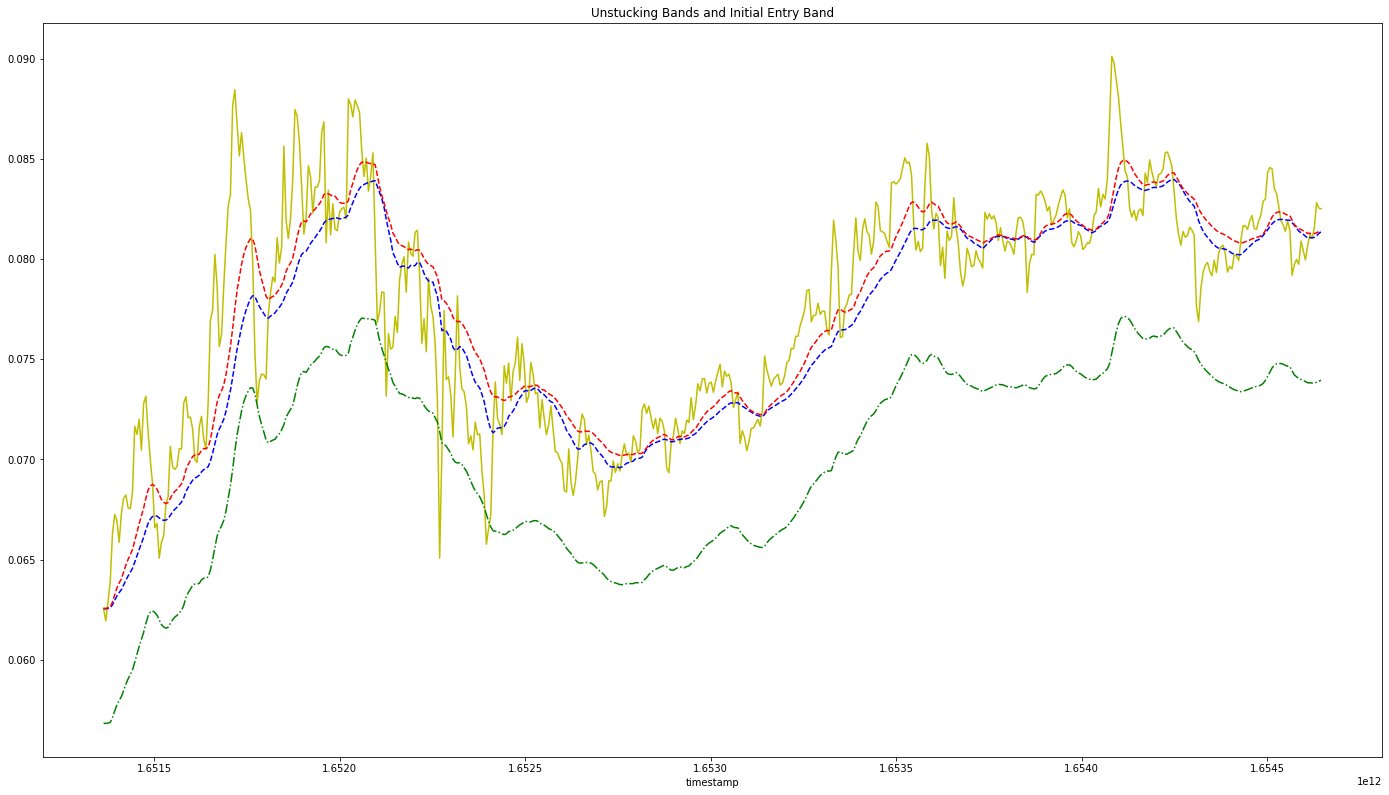

In [22]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")

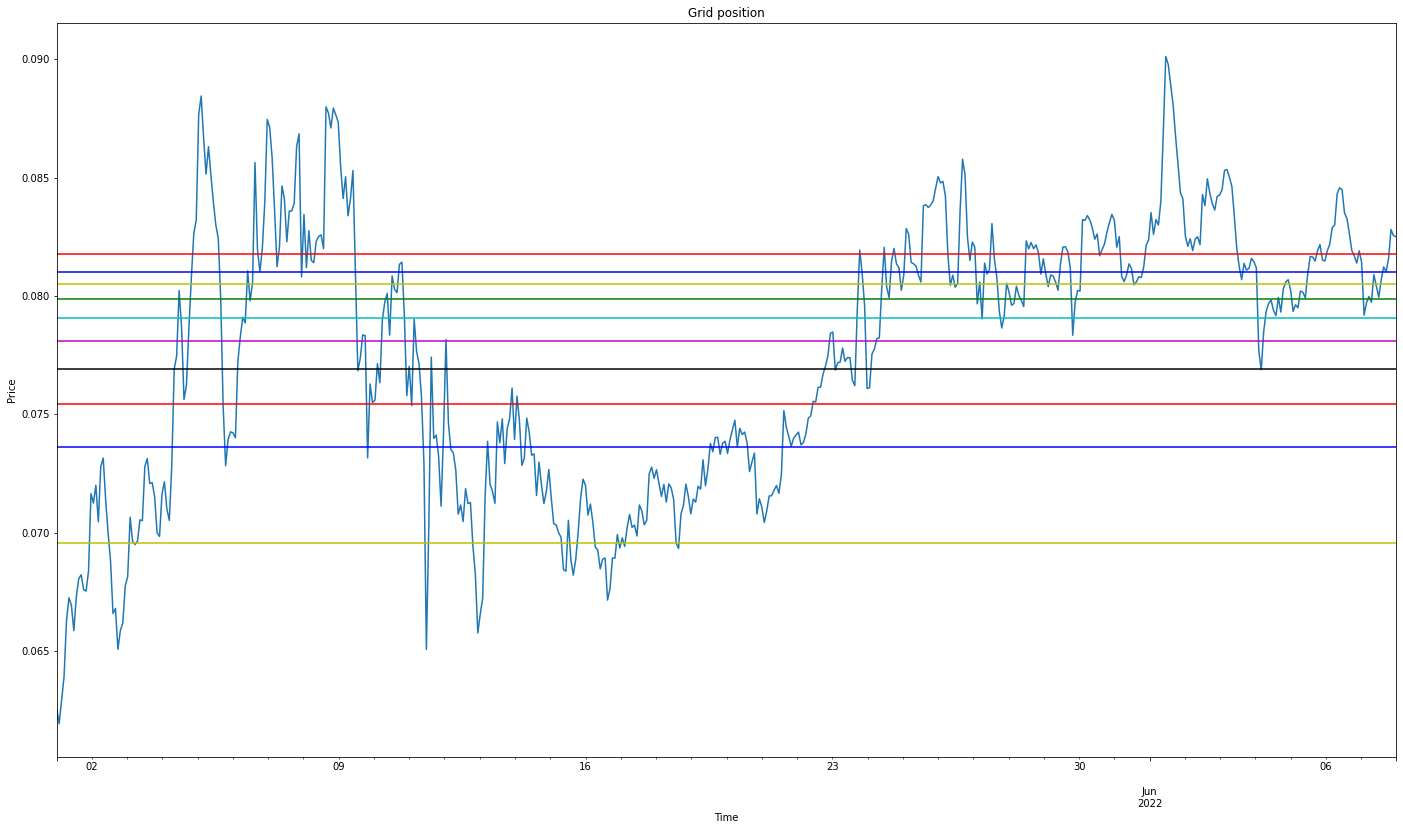

In [23]:
balance = config_to_test["starting_balance"]
highest_bid = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_long = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["long"]["grid_span"]
wallet_exposure_limit = config_to_test["long"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["long"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["long"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["long"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["long"]["eprice_exp_base"]
secondary_allocation = config_to_test["long"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["long"]["secondary_pprice_diff"]

grid = calc_whole_entry_grid_long(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [24]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nLong Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Long Grid Span = 14.93 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,514.0,0.08179,514.0,0.0817900000,0.004204006,0.0000000000,NaN,0.0
1,273.0,0.08102,787.0,0.0815228971,0.006415852,0.0062070733,0.5311284047,0.0
2,537.0,0.08050,1324.0,0.0811080211,0.010738702,0.0075530577,0.6823379924,0.0
3,705.0,0.07986,2029.0,0.0806743815,0.016368832,0.0101976142,0.5324773414,0.0
4,971.0,0.07908,3000.0,0.0801583333,0.024047500,0.0136359804,0.4785608674,0.0
5,1314.0,0.07810,4314.0,0.0795313862,0.034309840,0.0183276080,0.4380000000,0.0
6,1687.0,0.07690,6001.0,0.0787916514,0.047282870,0.0245988477,0.3910523876,0.0
7,2221.0,0.07543,8222.0,0.0778835721,0.064035873,0.0325278022,0.3701049825,0.0
8,2940.0,0.07361,11162.0,0.0767579403,0.085677213,0.0427651180,0.3575772318,0.0
9,2058.0,0.06958,13220.0,0.0756405272,0.099996777,0.0871015699,0.1843755599,0.0


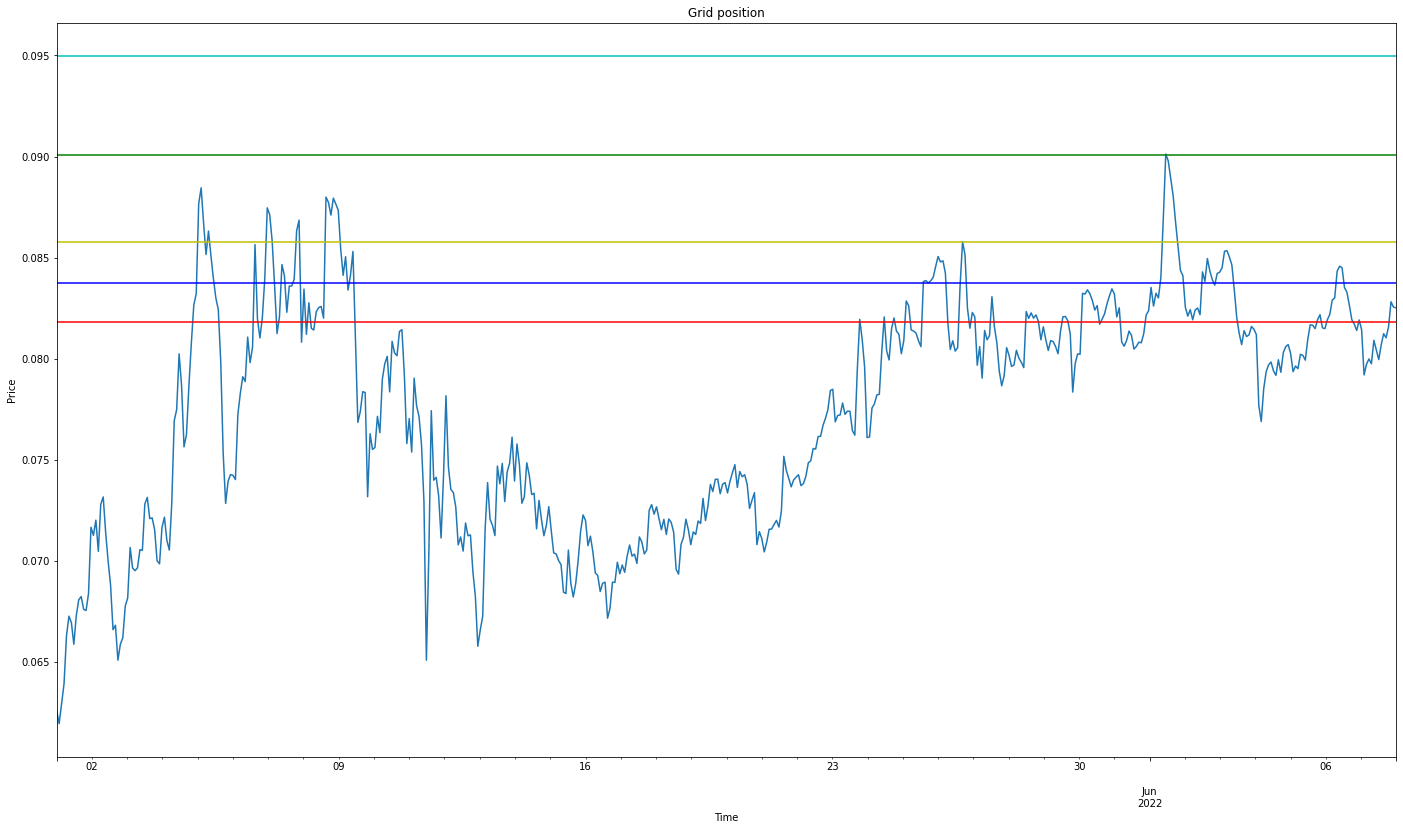

In [25]:
balance = config_to_test["starting_balance"]
lowest_ask = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_short = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["short"]["grid_span"]
wallet_exposure_limit = config_to_test["short"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["short"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["short"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["short"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["short"]["eprice_exp_base"]
secondary_allocation = config_to_test["short"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["short"]["secondary_pprice_diff"]

grid = calc_whole_entry_grid_short(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [26]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nShort Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Short Grid Span = -16.09 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,-544.0,0.08179,-544.0,0.0817900000,0.004449376,0.0000000000,NaN,18.4641429412
1,-331.0,0.08372,-875.0,0.0825200914,0.007220508,0.0143324005,0.6084558824,11.5110915200
2,-1453.0,0.08579,-2328.0,0.0845609751,0.019685795,0.0143259694,1.6605714286,4.3800936211
3,-7595.0,0.09006,-9923.0,0.0887698932,0.088086365,0.0143249703,3.2624570447,1.0965296433
4,-1255.0,0.09495,-11178.0,0.0894637592,0.100002590,0.0577803142,0.1264738486,0.9840781804
